# Polynômes de chaos : application au cas de la poutre encastrée


## Résumé

Dans ce notebook, nous présentons la décomposition en chaos polynomial du cas de la poutre encastrée. Nous montrons comment obtenir les indices de Sobol' à partir d'un chaos polynomial.

# Problem statement

We consider a cantilever beam defined by its Young’s modulus $E$, its length $L$ and its section modulus $I$. One end is built in a wall and we apply a concentrated bending load $F$ at the other end of the beam, resulting in a vertical deviation $Y$.

<img src="poutre.png" width="200">

**Figure 1.** Vertical deviation $Y$ of the cantilever beam of length $L$.

__Inputs__:

* $E$ : Young modulus (Pa),
* $F$ : Loading (N),
* $L$ : Length of beam (cm),
* $I$ : Moment of inertia (cm^4).

|Variable|  Distribution|
| ------------- |-------------|
|E| Beta(alpha = 0.9, beta = 2.2, a = $2.8\times 10^7$, $b = 4.8\times 10^7$) |
|F| Lognormal($\mu_F=3 \times 10^4$, $\sigma_F=9\times 10^3$, shift=$15\times 10^3$)|
|L| Uniform(min=250, max= 260)|
|I| Beta(alpha = 2.5, beta = 1.5, a = 310, b = 450)|

**Table 1.** Marginal distributions of the variables E, F, L and I.

The input variables are supposed to be independent.

__Output__:

The vertical displacement at free end of the cantilever beam is:
$$
Y  = \dfrac{F\, L^3}{3 \, E \, I}
$$

## Un guide pour le chaos polynomial creux dans OpenTURNS

Voici les étapes principales et les objets pour créer un polynôme de chaos creux par régression.
* Créer un plan d'expériences (de type `Sample`) et évaluer les sorties de la fonction $g$
* Créer la base polynomiale multivariée avec la classe `OrthogonalProductPolynomialFactory`. 
  * La règle par défaut `StandardDistributionPolynomialFactory` sélectionne automatiquement la famille de polynômes en fonction de la distribution ou bien l'orthogonalise si elle n'existe pas. Si nécessaire, personnaliser la famille polynomiale univariée pour chaque marginale (par exemple, pour la variable log-normale). 
  * Si nécessaire, personnaliser la règle d'énumération avec `HyperbolicAnisotropicEnumerateFunction`.
* Choisir une méthode de sélection de modèle avec `LeastSquaresMetaModelSelectionFactory`. 
  * Par défaut, l'algorithme de sélection de modèle permettant de créer la hiérarchie de modèles du plus creux au moins creux est la méthode "Least Angle Regression Stepwise" (LARS). 
  * Par défaut, l'algorithme de choix du meilleur modèle dans la hiérarchie de modèles est la méthode `CorrectedLeaveOneOut`. Si nécessaire, choisir `KFold`. 
* Choisir une règle de calcul des coefficients du polynôme du chaos avec la classe `LeastSquaresStrategy`. Une alternative serait de calculer les coefficients par intégration avec `IntegrationStrategy`.
* Choisir une méthode de troncature pour déterminer combien de coefficients seront retenus dans l'exploration des modèles. La méthode de base est d'utiliser un nombre fixe avec `FixedStrategy`. L'alternative est la classe `SequentialStrategy` dont l'objectif est de conserver au plus un nombre donné de coefficients. 
* Mélangez les ingrédients; votre `FunctionalChaosAlgorithm` est prêt !

Un guide plus complet est disponible dans [guide-chaos-polynomial.md](https://github.com/mbaudin47/otsupgalilee-eleve/blob/master/5-Chaos/guide-chaos-polynomial.md) avec, en particulier, plusieurs méthodes pour améliorer la qualité de prévision du chaos polynomial.

## Pourquoi utiliser une méthode de sélection de modèle

Lorsqu'on utilise le chaos polynomial "classique" ou plein, on peut tenter d'améliorer la qualité du métamodèle en augmentant le degré du polynôme. La difficulté de cette approche est que le nombre de coefficients à estimer augmente très rapidement en fonction de la dimension d'entrée $p$ du vecteur aléatoire $\mathbf{X}$ et du degré $d$ du polynôme. Ce conduit à estimer un grand nombre de coefficients. Si la taille du plan d'expérience est fixée, chaque coefficient est donc de plus en plus mal estimé lorsque le degré augmente. En parallèle, la résolution nécessite de plus en plus de temps CPU lorsqu'on utilise la méthode d'estimation par régression, car le système d'équations à résoudre est de plus en plus grand. Enfin, cela conduit au sur-apprentissage: le méta-modèle possède une grande erreur de prédiction lorsqu'on le teste sur un plan d'expérience de validation différent du plan d'expériences utilisé pour l'apprentissage.

Plus de détails sur le thème du sur-apprentissage et la nécessité de la sélection de modèle sont disponibles dans [Over-fitting-model-selection.ipynb](https://github.com/mbaudin47/otsupgalilee-eleve/blob/master/5-Chaos/Over-fitting-model-selection.ipynb). 

## References

* http://openturns.github.io/openturns/master/auto_meta_modeling/polynomial_chaos_metamodel/plot_chaos_beam_sensitivity_degree.html

# Model definition

In [1]:
import openturns as ot
import openturns.viewer as otv
import numpy as np

In [2]:
dist_E = ot.Beta(0.9, 2.2, 2.8e7, 4.8e7)
dist_E.setDescription(["E"])
F_para = ot.LogNormalMuSigma(3.0e4, 9.0e3, 15.0e3)  # in N
dist_F = ot.ParametrizedDistribution(F_para)
dist_F.setDescription(["F"])
dist_L = ot.Uniform(250.0, 260.0)  # in cm
dist_L.setDescription(["L"])
dist_I = ot.Beta(2.5, 1.5, 310.0, 450.0)  # in cm^4
dist_I.setDescription(["I"])

myDistribution = ot.JointDistribution([dist_E, dist_F, dist_L, dist_I])

dim_input = 4  # dimension of the input
dim_output = 1  # dimension of the output


def function_beam(X):
    E, F, L, I = X
    Y = F * L**3 / (3 * E * I)
    return [Y]


g = ot.PythonFunction(dim_input, dim_output, function_beam)
g.setInputDescription(myDistribution.getDescription())

## Create a polynomial chaos decomposition

Pour simplifier l'utilisation du polynôme du chaos, nous avons créé la fonction suivante qui permet de créer un polynôme du chaos creux par moindres carrés linéaires avec un nombre réduit de paramètres. 

In [3]:
def ComputeSparseLeastSquaresChaos(
    inputTrain, outputTrain, multivariateBasis, totalDegree, myDistribution
):
    """
    Create a sparse polynomial chaos with least squares.

    * Uses the enumeration rule from multivariateBasis.
    * Uses LeastSquaresStrategy to compute the coefficients from
    linear least squares.
    * Uses LeastSquaresMetaModelSelectionFactory to select the polynomials
    in the basis using least angle regression stepwise (LARS)
    * Utilise LeastSquaresStrategy pour calculer les
    coefficients par moindres carrés.
    * Uses FixedStrategy to keep all coefficients that LARS has selected,
    up to the given maximum total degree.

    Parameters
    ----------
    inputTrain : ot.Sample(n)
        The input training design of experiments with n points
    outputTrain : ot.Sample(n)
        The input training design of experiments with n points
    multivariateBasis : ot.Basis
        The multivariate orthogonal polynomial basis
    totalDegree : int
        The maximum total polynomial degree
    myDistribution : ot.Distribution
        The distribution of the input random vector

    Returns
    -------
    result : ot.FunctionalChaosResult
        The polynomial chaos result
    """
    selectionAlgorithm = ot.LeastSquaresMetaModelSelectionFactory()
    projectionStrategy = ot.LeastSquaresStrategy(
        inputTrain, outputTrain, selectionAlgorithm
    )
    enumerateFunction = multivariateBasis.getEnumerateFunction()
    maximumBasisSize = enumerateFunction.getBasisSizeFromTotalDegree(totalDegree)
    adaptiveStrategy = ot.FixedStrategy(multivariateBasis, maximumBasisSize)
    chaosalgo = ot.FunctionalChaosAlgorithm(
        inputTrain, outputTrain, myDistribution, adaptiveStrategy, projectionStrategy
    )
    chaosalgo.run()
    result = chaosalgo.getResult()
    return result

On crée la base polynomiale multivariée par tensorisation de polynômes univariés avec la règle d'énumération linéaire par défaut.

In [4]:
multivariateBasis = ot.OrthogonalProductPolynomialFactory(
    [dist_E, dist_F, dist_L, dist_I]
)

On crée un échantillon d'apprentissage Monte-Carlo simple de taille $n = 50$. 

In [5]:
training_sample_size = 100  # Size of the training design of experiments

inputTrain = myDistribution.getSample(training_sample_size)
outputTrain = g(inputTrain)

totalDegree = 5  # Polynomial degree
result = ComputeSparseLeastSquaresChaos(
    inputTrain, outputTrain, multivariateBasis, totalDegree, myDistribution
)
result

Index,Multi-index,Coeff.
0,"[0,0,0,0]",12.55879
1,"[1,0,0,0]",-1.522873
2,"[0,1,0,0]",3.714043
3,"[0,0,1,0]",0.3997467
4,"[0,0,0,1]",-0.9080676
5,"[2,0,0,0]",0.1800135
6,"[1,1,0,0]",-0.3722549
7,"[1,0,0,1]",0.1060847
8,"[0,2,0,1]",0.2160007
9,"[2,2,0,0]",-0.004564041


La méthode `getMetaModel` retourne une fonction permettant d'évaluer le métamodèle.

In [6]:
metamodel = result.getMetaModel()
type(metamodel)

openturns.func.Function

## Valider le méta-modèle

Avant d'utiliser le méta-modèle, il est nécessaire de valider sa qualité.

Pour vérifier la qualité du métamodèle, nous créons un échantillon de test. Puisque c'est un modèle physique peu coûteux, nous choisissons un échantillon de test de taille égale à 1000, ce qui est relativement grand. 

In [7]:
test_sample_size = 1000  # Size of the validation design of experiments
inputTest = myDistribution.getSample(test_sample_size)
outputTest = g(inputTest)

La classe `MetaModelValidation` permet de valider le métamodèle sur une base de validation.

In [8]:
val = ot.MetaModelValidation(outputTest, metamodel(inputTest))

La méthode `computeR2Score` retourne la valeur du score $Q^2$ sur l'échantillon de test. 

In [9]:
Q2 = val.computeR2Score()[0]
Q2

0.9901625812323392

Le métamodèle est ici d'excellente qualité, puisque le $Q^2$ est supérieur à 99%. Cela signifie que moins de 1% de la variance de la sortie est perdue en substituant le métamodèle au modèle. 

Pour valider graphiquement la qualité du métamodèle, nous utilisons la méthode `drawValidation` qui affiche en abscisse les valeurs du modèle et en ordonnée les valeurs du métamodèle. Le métamodèle est de qualité si les points sont proches de la première bissectrice, indiquée en rouge sur le graphique. En effet, cela signifie que les prédictions du métamodèle sont proche des observations du modèle. 

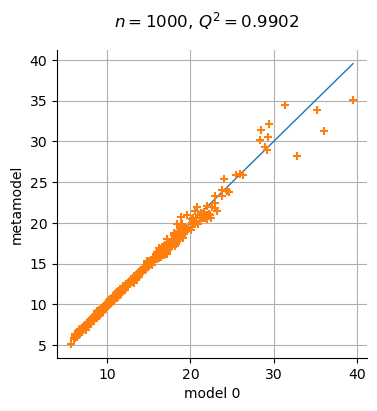

In [10]:
graph = val.drawValidation()
graph.setTitle(r"$n = %d$, $Q^2 = %.4f$" % (test_sample_size, Q2))
view = otv.View(graph, figure_kw={"figsize": (4.0, 4.0)})

La validation est satisfaisante : la plupart des points sont proches de la première bissectrice. Seuls quelques points associés à des grandes déviations sont un peu plus éloignés. 

## Moyenne et variance du chaos polynomial

On peut ensuite obtenir la moyenne et l'écart-type du polynôme du chaos en utilisant la classe `FunctionalChaosRandomVector`.  

In [11]:
chaosRV = ot.FunctionalChaosRandomVector(result)
mean = chaosRV.getMean()[0]
variance = chaosRV.getCovariance()[0, 0]
stdDev = np.sqrt(variance)
print("Mean(PC) = %.4f" % (mean))
print("S.D.(PC) = %.4f" % (stdDev))

Mean(PC) = 12.5588
S.D.(PC) = 4.1634


Comme pour tout autre `RandomVector`, on peut utiliser la méthode `getSample()` pour produire un échantillon de la sortie du polynôme du chaos.

In [12]:
chaosRV.getSample(5)

,v0
0,14.33243
1,16.33932
2,10.56789
3,11.21695
4,7.465541


## Analyse de sensibilité

On souhaite estimer les indices de Sobol' issus de la décomposition en chaos polynomial avec la classe `FunctionalChaosSobolIndices`. Le "_pretty-print_" permet d'afficher les données les plus importantes, c'est à dire la dimension d'entrée et de sortie, la taille de la base fonctionnelle polynomiale, la moyenne, l'écart-type ainsi que les multi-indices triés par part de variance décroissante. 

In [13]:
chaosSI = ot.FunctionalChaosSobolIndices(result)
chaosSI

class=FunctionalChaosSobolIndices functional chaos result=class=FunctionalChaosResult derived from  metaModel=class=Function name=Unnamed implementation=class=ComposedFunction name=Unnamed description=[E,F,L,I,y0] left function=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,v0] evaluationImplementation=class=DualLinearCombinationEvaluation functions=[class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,y0] evaluationImplementation=class=ProductPolynomialEvaluation, polynomials=[class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1]] gradientImplementation=class=ProductPolynomialGradient hessianImplementation=class=ProductPolynomialHessian,class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,y0] evaluationImplementation=class=ProductPolynomialEvaluation, polynomials=[class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=2 values=[0.935347,2.23044],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1]] gradientImplementation=class=ProductPolynomialGradient hessianImplementation=class=ProductPolynomialHessian,class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,y0] evaluationImplementation=class=ProductPolynomialEvaluation, polynomials=[class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=2 values=[-1.66667,0.000111111],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1]] gradientImplementation=class=ProductPolynomialGradient hessianImplementation=class=ProductPolynomialHessian,class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,y0] evaluationImplementation=class=ProductPolynomialEvaluation, polynomials=[class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=2 values=[0,1.73205],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1]] gradientImplementation=class=ProductPolynomialGradient hessianImplementation=class=ProductPolynomialHessian,class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,y0] evaluationImplementation=class=ProductPolynomialEvaluation, polynomials=[class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=2 values=[-0.57735,2.3094]] gradientImplementation=class=ProductPolynomialGradient hessianImplementation=class=ProductPolynomialHessian,class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,y0] evaluationImplementation=class=ProductPolynomialEvaluation, polynomials=[class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=3 values=[-0.755511,2.3618,4.63277],class=UniVariatePolynomial coeffi

On observe que la variable ayant l'indice de Sobol total le plus grand est la seconde variable $F$ : son indice de Sobol' du premier ordre est égal à 0.77. De plus, le multi-indice $(0, 1, 0, 0)$ est associé à une part de variance égale à 0.77 : en d'autres termes, le polynôme de degré 1 en la variable standardisée associée à $F$ génère 77% de la variance.

La classe `SobolIndicesAlgorithm` peut être utilisée pour dessiner les indices de Sobol'. 

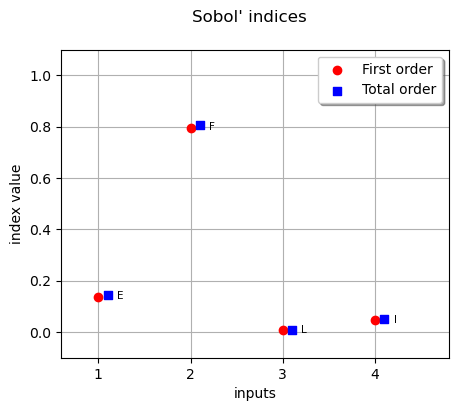

In [14]:
first_order = [chaosSI.getSobolIndex(i) for i in range(dim_input)]
total_order = [chaosSI.getSobolTotalIndex(i) for i in range(dim_input)]
input_names = g.getInputDescription()
graph = ot.SobolIndicesAlgorithm.DrawSobolIndices(input_names, first_order, total_order)
view = otv.View(graph, figure_kw={"figsize": (5.0, 4.0)})

On observe que la variable $F$ est la plus influente sur la variabilité de la sortie. La variable $L$ pourraît être remplacée par une constante, puisque son indice de Sobol' total est proche de zéro.

## Exercice 1 : faire varier la taille du plan d'expériences d'apprentissage

Dans cette exercice, on souhaite étudier la sensibilité du coefficient de prédictivité $Q^2$ à deux paramètres essentiels de la méthode:

* la taille du plan d'expériences d'apprentissage ;
* le degré du polynôme.

**Questions**

* Utiliser un plan d'expériences d'apprentissage de taille `N = 25`. Exécuter à nouveau l'analyse. Répéter l'opération avec `N = 50`.
* Calculer le coefficient de prédictivité $Q^2$ (noter la valeur numérique).
* Afficher le graphique de validation du métamodèle. Que peut-on conclure ?
* Exécuter à nouveau l'analyse pour voir l'influence de l'échantillon d'apprentissage sur les résultats. 
* Utiliser un plan d'expériences de taille `N = 100`. Exécuter à nouveau l'analyse : observer l'impact sur  les résultats numériques. 
* Etudier la sensibilité du coefficient de prédictivité en fonction de la taille du plan d'expériences et du degré du polynôme. Pour chaque combinaison testée, relever la valeur du coefficient de prédictivité $Q^2$. Pour cela, compléter le tableau suivant:

| Taille du plan | Degré du polynôme | $Q^2$ |
|--|--|--|
| 50 | 1 | TODO |
| 50 | 2 | TODO |
| 50 | 5 | TODO |
| 25 | 5 | TODO |
| 100 | 5 | TODO |


* Pouvez-vous identifier 5 méthodes pour améliorer la qualité du métamodèle ?

## Exercice 2 : pourquoi éviter le calcul du R2

L'objectif de cet exercice est de clarifier le rôle d'un plan d'expériences d'apprentissage en comparaison d'un plan d'expériences de validation. À travers le calcul des coefficients $R^2$ et $Q^2$, nous analysons le problème du surapprentissage d'un métamodèle.

Soit $\mathcal{A} = \left\{\boldsymbol{x}^{(j)}_a\right\}_{j=1,...,n}$ un échantillon i.i.d. du vecteur aléatoire $\boldsymbol{X}$ que nous allons utiliser pour la phase d'apprentissage du métamodèle. On note $g$ le modèle et $\widetilde{g}$ le métamodèle. Soient :

$$
y^{(j)}_a = g\left(\boldsymbol{x}^{(j)}_a\right), \qquad \widetilde{y}^{(j)}_a = \widetilde{g}\left(\boldsymbol{x}^{(j)}_a\right)
$$

pour $j=1,...,n$ les sorties du modèle et du métamodèle sur la base d'apprentissage. 
Le coefficient $R^2$ est :

$$
R^2 \left(g(\boldsymbol{x}_a), \widetilde{g}(\boldsymbol{x}_a)\right) 
= 1 - \frac{ \sum_{j=1}^n \left( y^{(j)}_a - \widetilde{y}^{(j)}_a \right)^2  }{ \sum_{j=1}^n \left( y^{(j)}_a - \overline{y}_a \right)^2 }
$$

où $\overline{y}_a = \frac{1} {n} \sum_{i=1}^n y^{(j)}_a$. 
Observons que le métamodèle n'est impliqué que dans le numérateur de la fraction. 

Supposons qu'un second plan d'expériences de validation du métamodèle est généré, noté $\mathcal{V} = \left\{\boldsymbol{x}^{(j)}_v\right\}_{j=1,...,n}$. Supposons, de plus, que ce second plan d'expériences de validation est indépendant du premier. L'objectif de ce second plan d'expériences est de tester le métamodèle sur des points d'entrées que le métamodèle n'a pas considéré pour estimer ses coefficients.

Soient $g(\boldsymbol{x}_v)$ et $\widetilde{g}(\boldsymbol{x}_v)$ les sorties du modèle et du métamodèle sur le plan d'expériences de validation. 
Dans ce contexte, le coefficient $Q^2$ est égal au coefficient $R^2$ appliqué au plan d'expériences de validation :

$$
Q^2 = R^2 \left(g\left(\boldsymbol{x}_v\right), \widetilde{g}\left(\boldsymbol{x}_v\right)\right).
$$

Dans le contexte de tout métamodèle, et en particulier du chaos polynomial, il est plus prudent d'utiliser le coefficient $Q^2$ pour vérifier la qualité du métamodèle. En effet, lorsque le nombre de coefficients dans le chaos polynomial est suffisamment grand relativement à la taille du plan d'expériences, le coefficient $R^2$ peut laisser penser à un modèle de bonne qualité (i.e. proche de 1), mais le coefficient $Q^2$ peut révéler un modèle de mauvaise qualité (i.e. proche de 0). Cette situation est caractéristique d'un surapprentrissage.

**Questions**

- Utiliser la méthode `getRelativeErrors` de l'objet `result` (de type `FunctionalChaosResult`). 
Cette fonction retourne la valeur de :
$$
\frac{ \sum_{j=1}^n \left( y^{(j)}_a - \widetilde{y}^{(j)}_a \right)^2  }{ \sum_{j=1}^n \left( y^{(j)}_a - \bar{y}_a \right)^2 }
$$
- Calculer le coefficient $R^2$.
- Qu'observez-vous ?

## Exercice 3 : décroissance des coefficients

La fonction suivante produit un graphique présentant l'évolution de la valeur absolue des coefficients du chaos polynomial en fonction du degré de chaque terme polynomial dans la décomposition.

In [15]:
def plotCoefficientValueVSDegree(polynomialChaosResult):
    """
    Create a plot of total degree vs absolute value of coefficients.

    Parameters
    ----------
    polynomialChaosResult : ot.FunctionalChaosResult
        The polynomial chaos result

    Returns
    -------
    graph : ot.Graph
        A plot.
    """
    basis = polynomialChaosResult.getOrthogonalBasis()
    enumerate_function = basis.getEnumerateFunction()
    # Get coefficients
    coefficients = polynomialChaosResult.getCoefficients()
    abscoeff = [abs(coefficients[i][0]) for i in range(len(coefficients))]
    # Get total degree
    indices = result.getIndices()
    nbcoeffs = indices.getSize()
    total_p = []
    for k in range(nbcoeffs):
        multiindex = enumerate_function(indices[k])
        totaldegree = sum(multiindex)
        total_p.append(totaldegree)
    #
    graph = ot.Graph(
        "Polynomial chaos result",
        "Total polynomial degree",
        "Coefficient absolute value",
        True,
    )
    cloud = ot.Cloud(total_p, abscoeff)
    graph.add(cloud)
    return graph

**Questions**

* Utiliser la fonction `plotCoefficientValueVSDegree` sur le résultat du chaos polynomial : qu'observez-vous ?

## Exercice 4 : énumération hyperbolique et plan d'expériences de taille 25

We want to see the behaviour of the hyperbolic enumeration rule and see the result of the polynomial chaos expansion. 

**Questions**

* Use an hyperbolic enumeration with a training sample size equal to $n = 25$. 
* Compute the $Q^2$ coefficient. 
* Plot the metamodel validation graphics.
* Is the quality of the chaos acceptable ?

## Exercice 5 : nombre d'observations et nombre de paramètres

On souhaite vérifier que le nombre d'observations est suffisant pour estimer correctement les paramètres. 

**Questions**

* Calculer le nombre de paramètres estimés dans le chaos polynomial. Pour cela, utiliser la méthode `getCoefficients` de l'objet `result` pour obtenir les coefficients du chaos polynomial. 
* Calculer le nombre d'observations dans le plan d'expériences. 
* Calculer le ratio entre le nombre d'observations et le nombre de paramètres. 
* La taille du plan d'expériences est-elle suffisante pour estimer les paramètres ?

## Exercice 6 : analyse des résultats de la sélection de modèle

L'objectif de cet exercice est d'analyser les résultats de la sélection de modèle dans le but de réaliser un diagnostique de la qualité du métamodèle obtenu.

Considérons le ratio :
```
nbcoeffs / P
```
où `nbcoeffs` est le nombre de coefficients retenus dans la décomposition et `P` est le nombre maximal de coefficients associé à la règle d'énumération. Ce ratio entre 0 et 1 représente la proportions de termes retenus dans la méthode de sélection de modèle. 
* Si ce ratio est proche de zéro (par exemple inférieur à 0.01), alors c'est que le modèle est très creux car un faible nombre de coefficients suffit pour bien représenter la fonction. Dans ce cas, on aurait peut-être pu obtenir une qualité équivalente en utilisant un calcul moins coûteux en diminuant la valeur de `P`.
* Si ce ratio est proche de un (par exemple supérieur à 0.99), alors c'est que le modèle est très plein car presque tous les coefficients ont étés nécessaires pour bien représenter la fonction. Dans ce cas, on devrait peut-être améliorer la qualité en utilisant en augmentant la valeur de `P` (cela sera plus coûteux en termes de temps de calcul, sans nécessairement nécessiter de nouvelles évaluations de la fonction $g$).

L'objectif de cet exercice est d'explorer les différentes méthodes de l'objet `result`, une instance de la classe `FunctionalChaosResult`.

**Questions**

* Utiliser la méthode `getIndices` pour créer la variable `indices` contenant la liste des indices des coefficients sélectionnés par la méthode. Afficher ces indices.
* Utiliser la méthode `getSize` de la variable `indices` pour obtenir le nombre de coefficients sélectionnés par la méthode.
* Utiliser la méthode `getCoefficients` pour obtenir la liste des valeurs des coefficients sélectionnés par la méthode. Afficher ces coefficients.
* Calculer le ratio `nbcoeffs / P`. Quelle est la valeur obtenue ? Que peut-on conclure relativement à la qualité du métamodèle ?
* La fonction `printCoefficientsTable` suivante utilise la règle d'énumération et le résultat d'un chaos polynomial pour afficher une table présentant les multi-indices, le degré du polynôme associé et la valeur du coefficient. 

In [16]:
def printCoefficientsTable(polynomialChaosResult):
    """
    Print the coefficients of the polynomial chaos.

    Parameters
    ----------
    enumerate_function : ot.EnumerateFunction
        The enumerate function.
    polynomialChaosResult : ot.PolynomialChaosResult
        The polynomial chaos result.
    """
    basis = polynomialChaosResult.getOrthogonalBasis()
    coefficients = polynomialChaosResult.getCoefficients()
    enumerate_function = basis.getEnumerateFunction()
    indices = polynomialChaosResult.getIndices()
    nbcoeffs = indices.getSize()
    print("# Indice, Multi-indice, Degree : Value")
    for k in range(nbcoeffs):
        multiindex = enumerate_function(indices[k])
        degree = sum(multiindex)
        c = coefficients[k][0]
        print("#%d, %s (%s) : %s" % (k, multiindex, degree, c))
    return

Utiliser la fonction `printCoefficientsTable` avec les résultats du calcul. Qu'observez-vous ?

## Exercice 7 : calculer la moyenne et l'écart-type du chaos polynomial

La classe `FunctionalChaosRandomVector` permet d'obtenir la moyenne et la variance du chaos polynomial. L'objectif de cet exercice est d'implémenter le même service en Python. Pour cela, utiliser le squelette de code suivant, où vous remplacerez les sections `TODO` par du code valide.

```python
def get_PC_mean_sd(functionalChaosResult):
    outputDimension = functionalChaosResult.getMetaModel().getOutputDimension()
    indices = functionalChaosResult.getIndices()
    coefficients = functionalChaosResult.getCoefficients()
    basisSize = indices.getSize()
    variance = ot.Point(outputDimension)
    mean = ot.Point(outputDimension)
    for i in range(outputDimension):
        for k in range(basisSize):
            TODO
    # standard deviation
    stdDev = ot.Point(outputDimension)
    for i in range(outputDimension):
            TODO
    return mean, stdDev
```


**Questions**

- Evaluer la moyenne et l'écart-type grâce à la fonction `get_PC_mean_sd`.
- Comparez les valeurs numériques aux valeurs numériques obtenues par `FunctionalChaosRandomVector`. 

## Exercice 8 : créer un polynôme de Wiener-Hermite

Un polynôme du chaos de Wiener-Hermite utilise exclusivement les polynômes de Hermite comme base de fonctions. Pour créer la base, on peut utiliser les instructions suivantes.

```python
dimension = myDistribution.getDimension()
hermiteFactory = ot.HermiteFactory()
multivariateBasis = ot.OrthogonalProductPolynomialFactory(
    [hermiteFactory] * dimension, enumerateFunction
)
```

**Questions**

- Créer un polynôme du chaos avec cette base multivariée et estimer son score $Q^2$ avec un échantillon de test.
- Qu'observez-vous ?
- Quel pourrait être l'avantage d'une telle méthode ? 
- Quels pourraient être les inconvénients ?

## Exercice 9 : approximation de la distribution de la sortie

Dans (Blatman, 2009) page 69, l'auteur propose d'approcher la distribution de la sortie du polynôme par une méthode d'estimation par lissage à noyau. Cette méthode permet d'approcher la distribution de la sortie du modèle par une méthode plus précise et moins coûteuse que l'échantillonnage Monte-Carlo simple.

**Questions**

- Créer un polynôme du chaos de degré 5 avec un plan d'expériences Monte-Carlo simple de taille $n = 100$. 
- Créer l'objet `FunctionalChaosRandomVector` associé et générer un plan d'expériences de taille $n = 1000$ de la sortie du polynôme du chaos.
- Utiliser la classe `KernelSmoothing` pour approcher la distribution de la sortie du polynôme. Dessiner cette distribution. 
- Dessiner la distribution approchée par lissage à noyau issue de l'échantillon de taille $n = 100$ utilisé pour l'apprentissage.
- Créer un échantillon de taille $n = 1000$ de la sortie du modèle physique. Utiliser la méthode de lissage à noyau pour approcher la distribution de la sortie du modèle physique. 
- Comparer les trois méthodes précédentes : que peut-on conclure ?

**Référence**

- Géraud Blatman. _"Adaptive sparse polynomial chaos expansions for uncertainty propagation and sensitivity analysis"_. Thèse. Université Blaise Pascal - Clermont II. Octobre 2009.

## Annexe : créer un polynôme du chaos pas à pas

On présente ci-dessous une méthode créer un polynôme du chaos étape par étape. 

On doit d'abord choisir la méthode de sélection de modèle. C'est la méthode qui permet de sélectionner les polynômes dans la base polynomiale crée par la règle d'énumération. 

In [17]:
selectionAlgorithm = ot.LeastSquaresMetaModelSelectionFactory()

Par défaut, c'est l'algorithme de sélection de modèle LARS qui est utilisé.

In [18]:
selectionAlgorithm.getBasisSequenceFactory()

class=LARS

Par défaut, c'est le critère de leave-one-out (corrigé) qui est utilisé par la méthode de sélection de modèle.

In [19]:
selectionAlgorithm.getFittingAlgorithm()

class=CorrectedLeaveOneOut

Définit la règle de calcul des coefficients ; nous choisissons la méthode par résolution d'un problème de moindres carrés linéaires.

In [20]:
projectionStrategy = ot.LeastSquaresStrategy(
    inputTrain, outputTrain, selectionAlgorithm
)

Nous devons choisir une règle de troncature : ici, nous avons choisit la `FixedStrategy`, ce qui revient à conserver les `P` premiers polynômes de la base de polynômes. Dans notre cas particulier, nous avons déterminé `P` en utilisant la méthode  `getBasisSizeFromTotalDegree`, de telle sorte que c'est l'ensemble des polynômes multivariés de degré total inférieur ou égal à 5 qui est conservé. Cela implique que la somme des degrés marginaux est inférieure ou égale à 5. 

In [21]:
totalDegree = 5
enumerateFunction = multivariateBasis.getEnumerateFunction()
maximumBasisSize = enumerateFunction.getBasisSizeFromTotalDegree(totalDegree)
adaptiveStrategy = ot.FixedStrategy(multivariateBasis, maximumBasisSize)
adaptiveStrategy

class=FixedStrategy derived from class=AdaptiveStrategyImplementation maximumDimension=126

On observe que le nombre de polynômes correspondant à notre règle de troncature est égal à 126.

On peut maintenant créer le chaos fonctionnel en appelant la méthode `run`. 

In [22]:
chaosalgo = ot.FunctionalChaosAlgorithm(
    inputTrain, outputTrain, myDistribution, adaptiveStrategy, projectionStrategy
)
chaosalgo.run()

Get the result:

In [23]:
result = chaosalgo.getResult()  # get the result
type(result)

openturns.metamodel.FunctionalChaosResult